# Corona Tweets Classification using Keras:

## Package & Libraries:

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Embedding, Flatten, GlobalMaxPool1D, Conv1D
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from keras import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from ann_visualizer.visualize import ann_viz
import graphviz

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/spavot/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Using TensorFlow backend.


## Data reading

In [2]:
train = pd.read_csv('/Users/spavot/Documents/Perso/Text classification & Visualization/Data/Corona_NLP_train.csv', encoding = 'latin')
test = pd.read_csv('/Users/spavot/Documents/Perso/Text classification & Visualization/Data/Corona_NLP_test.csv', encoding ='latin')

## Data exploration:

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


* We see that we have 41157 values but we have only 32k non null values for location, we will have to fix this:

* UserName and ScreenName are id related data, we won't use it


Let's see which location is the more popular:

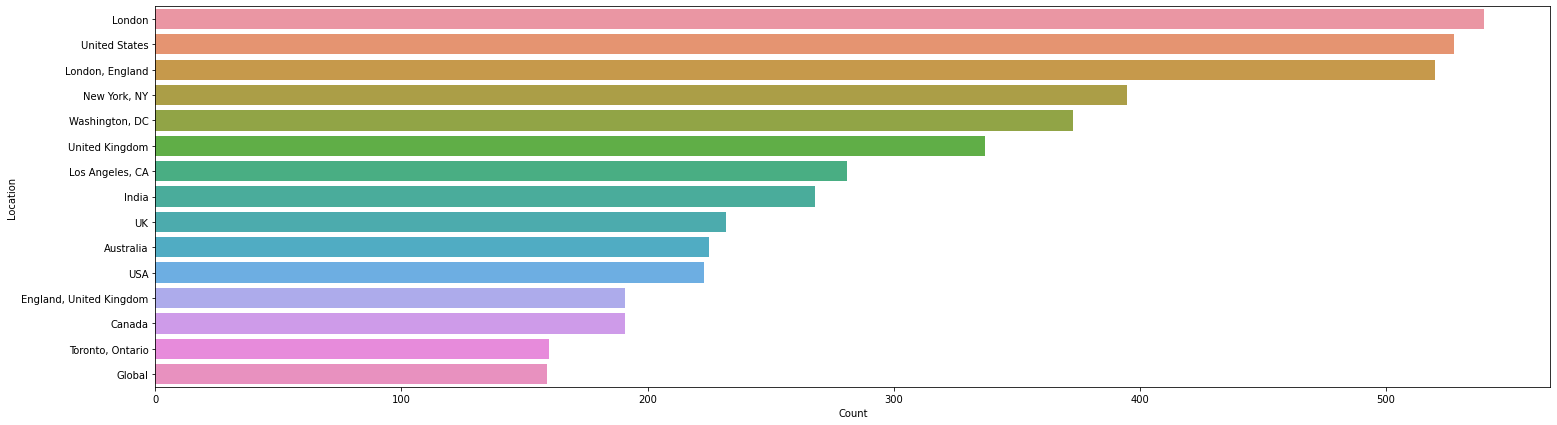

In [4]:
location = train.Location
location = pd.DataFrame(location)
location['Count'] = 1
location = location.groupby('Location').sum().sort_values(by = 'Count', ascending = False).nlargest(15,['Count'])
location = location.reset_index()
plt.figure(figsize=(25,7))
sns.barplot(x = 'Count', y = 'Location', data = location)
plt.show()

We can see that we have some noises and some location are country where other are cities

Now we want to have a look of the distribution of our target variable:

<AxesSubplot:xlabel='Sentiment', ylabel='count'>

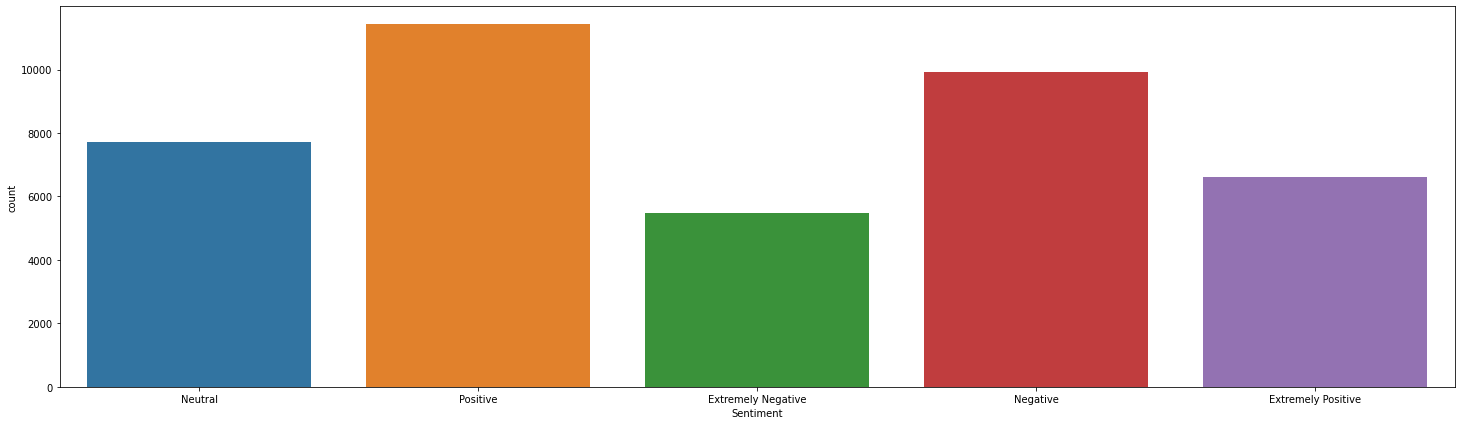

In [5]:
plt.figure(figsize=(25,7))
sns.countplot(train.Sentiment)

Seems like the target variable distribution is not skewed and we doesn't risk to have a category which is never predicted due to the lack of presence.

Let's look at the distribution of tweets over time:

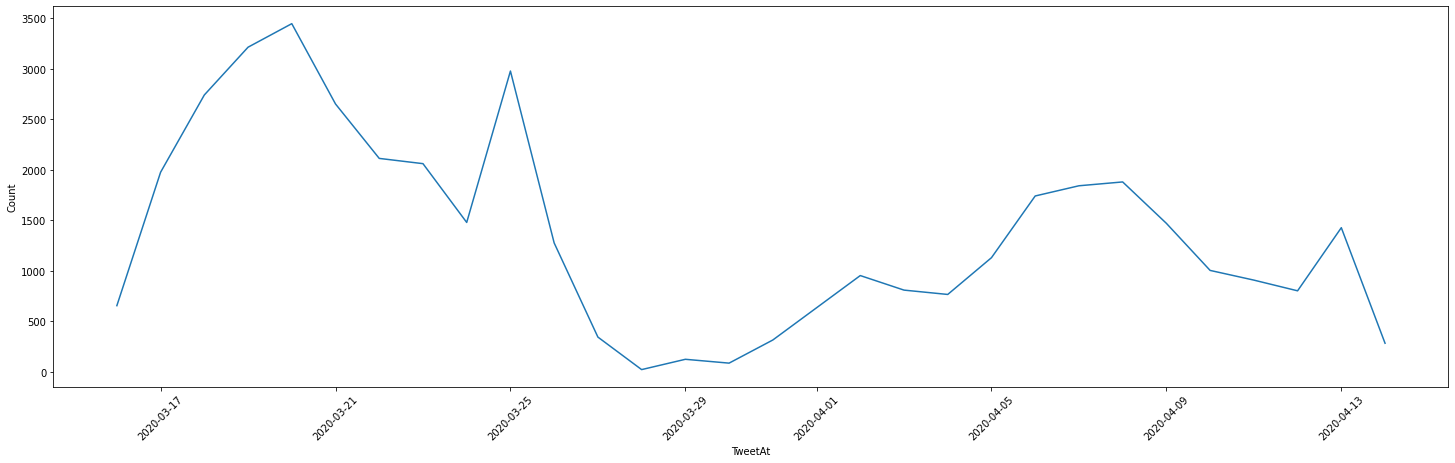

In [6]:
time = train.TweetAt
time = pd.DataFrame(time)
time['Count'] = 1
time = time.groupby('TweetAt').sum()
time = time.reset_index()
time = time.iloc[1:,:]
time['TweetAt'] = pd.to_datetime(time['TweetAt'], format = '%d-%m-%Y')
plt.figure(figsize=(25,7))
sns.lineplot(x = 'TweetAt', y = 'Count', data = time)
plt.xticks(rotation=45)
plt.show()

In [7]:
Min = time.TweetAt.min()
Max = time.TweetAt.max()
print(f'The date range of the data is between {Min} and {Max}')

The date range of the data is between 2020-03-16 00:00:00 and 2020-04-14 00:00:00


Seems like we have some day without data and some with a lot of tweets. The tweets are spread between 16 of March to 14 of April

Finally, let's analyze the lengths of tweets:

<AxesSubplot:ylabel='Density'>

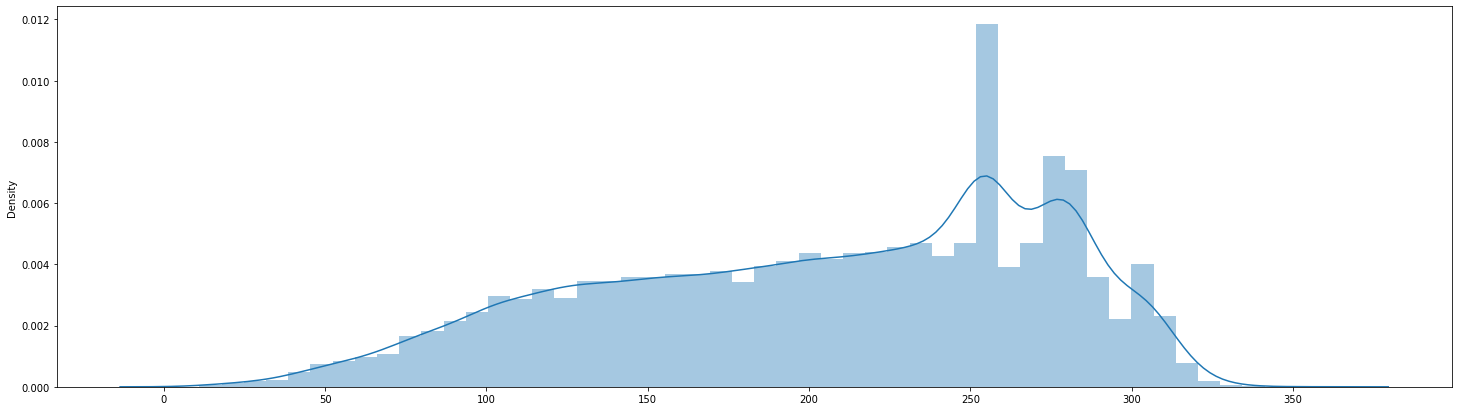

In [8]:
length_tweets = pd.DataFrame(train.OriginalTweet)
length_measured = []
for i in length_tweets.OriginalTweet:
 length_measured.append(len(i))

plt.figure(figsize=(25,7))
sns.distplot(length_measured)

It seems that the repartition is pretty well distributed, we can see a raise at 260 characters but overall we have tweets of all size. Note that we will have to check the length after processing the tweets

## Data cleaning:

### Drop variables

Let's first drop UserName and ScreenName as they are only id variables so we won't use them:

In [9]:
train = train.drop(['UserName','ScreenName'], axis = 1)
test = test.drop(['UserName','ScreenName'], axis = 1)

### Location variable

First, we will replace "NA" values with "Unknown"

In [10]:
train.Location = train.Location.fillna('Unknown')

Now we import a dataframe containg major cities in the word and countries in order join on it:

In [11]:
city_country = pd.read_csv('/Users/spavot/Documents/Perso/Text classification & Visualization/Data/world-cities.csv')

In [12]:
city_list = []

# for i in train.Location:
#     for y in city_country.name:
#         if y.lower() in i.lower():
#             city_name = y
#         else:
#             city_name = 'Unknown'
#     city_list.append(city_name)

In [13]:
# city_list = pd.DataFrame(city_list)
# city_list.value_counts()

We transform the TweetAt column into time variable:

### TweetAt Variable

In [14]:
train['TweetAt'] = pd.to_datetime(train['TweetAt'], format = '%d-%m-%Y')
test['TweetAt'] = pd.to_datetime(test['TweetAt'], format = '%d-%m-%Y')

### Original tweet cleaning

Now we will start fixing the tweets, we need to remove the punctuation and specific characters etc.. 

In [15]:
train.OriginalTweet.head(10)

0    @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...
1    advice Talk to your neighbours family to excha...
2    Coronavirus Australia: Woolworths to give elde...
3    My food stock is not the only one which is emp...
4    Me, ready to go at supermarket during the #COV...
5    As news of the regionÂs first confirmed COVID...
6    Cashier at grocery store was sharing his insig...
7    Was at the supermarket today. Didn't buy toile...
8    Due to COVID-19 our retail store and classroom...
9    For corona prevention,we should stop to buy th...
Name: OriginalTweet, dtype: object

In [16]:
#Transform to lower:
train.OriginalTweet = train.OriginalTweet.str.lower()
test.OriginalTweet = test.OriginalTweet.str.lower()

In [17]:
#Remove urls:
train.OriginalTweet = train.OriginalTweet.str.replace('http\S+|www.\S+', '', case=False)
test.OriginalTweet = test.OriginalTweet.str.replace('http\S+|www.\S+', '', case=False)

In [18]:
#Extract hastags & append them into a new column:
for data in train, test:
    Hashtags = []
    for i in range(0,len(data.OriginalTweet)):
        if len(re.findall(r"#(\w+)", data.OriginalTweet[i]))>0:
            Hashtags.append(re.findall(r"#(\w+)", data.OriginalTweet[i]))
        else:
            Hashtags.append('None')
    data['Hashtags'] =  Hashtags

In [19]:
train.head()

,Location,TweetAt,OriginalTweet,Sentiment,Hashtags
0,London,2020-03-16,@menyrbie @phil_gahan @chrisitv and and,Neutral,None
1,UK,2020-03-16,advice talk to your neighbours family to excha...,Positive,None
2,Vagabonds,2020-03-16,coronavirus australia: woolworths to give elde...,Positive,None
3,Unknown,2020-03-16,my food stock is not the only one which is emp...,Positive,"[covid19france, covid_19, covid19, coronavirus..."
4,Unknown,2020-03-16,"me, ready to go at supermarket during the #cov...",Extremely Negative,"[covid19, coronavirus, coronavirusfrance, rest..."


In [20]:
#Replace hashtags text now that we extracted it
train.OriginalTweet = train.OriginalTweet.apply(lambda x: ' '.join([word for word in x.split() if word[0] != '#']))
test.OriginalTweet = test.OriginalTweet.apply(lambda x: ' '.join([word for word in x.split() if word[0] != '#']))

In [21]:
#Remove punctuation, special characters & mentions:
train.OriginalTweet = train.OriginalTweet.str.replace(r'[^\w\s]', '', case=False)
test.OriginalTweet = test.OriginalTweet.str.replace(r'[^\w\s]', '', case=False)

In [22]:
#Remove stopwords:
stop_words = set(stopwords.words('english'))
train.OriginalTweet = train.OriginalTweet.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
test.OriginalTweet = test.OriginalTweet.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [23]:
#Remove non alphabetic words:
train.OriginalTweet = train.OriginalTweet.apply(lambda x: ' '.join([word for word in x.split() if word.isalpha()]))
test.OriginalTweet = test.OriginalTweet.apply(lambda x: ' '.join([word for word in x.split() if word.isalpha()]))

In [24]:
#Remove emptys rows:
train = train[train.OriginalTweet != '']
test = test[test.OriginalTweet != '']

Let's check if the cleaning seems okay:

In [25]:
for i in range(0,5):
    print(i,':',train.OriginalTweet[i])
    print(i,':',test.OriginalTweet[i])

0 : menyrbie chrisitv
0 : trending new yorkers encounter empty supermarket shelves pictured wegmans brooklyn soldout online grocers foodkick maxdelivery shoppers stock
1 : advice talk neighbours family exchange phone numbers create contact list phone numbers neighbours schools employer chemist gp set online shopping accounts poss adequate supplies regular meds order
1 : couldnt find hand sanitizer fred meyer turned pack purellcheck concerns driving prices
2 : coronavirus australia woolworths give elderly disabled dedicated shopping hours amid outbreak
2 : find protect loved ones
3 : food stock one empty please dont panic enough food everyone take need stay calm stay safe
3 : buying hits city anxious shoppers stock foodampmedical supplies worker becomes confirmed patient staged event
4 : ready go supermarket outbreak im paranoid food stock litteraly empty serious thing please dont panic causes shortage
4 : one week everyone buying baby milk powder next everyone buying toilet paper


In [26]:
train.head()

,Location,TweetAt,OriginalTweet,Sentiment,Hashtags
0,London,2020-03-16,menyrbie chrisitv,Neutral,None
1,UK,2020-03-16,advice talk neighbours family exchange phone n...,Positive,None
2,Vagabonds,2020-03-16,coronavirus australia woolworths give elderly ...,Positive,None
3,Unknown,2020-03-16,food stock one empty please dont panic enough ...,Positive,"[covid19france, covid_19, covid19, coronavirus..."
4,Unknown,2020-03-16,ready go supermarket outbreak im paranoid food...,Extremely Negative,"[covid19, coronavirus, coronavirusfrance, rest..."


In [27]:
test.head()

,Location,TweetAt,OriginalTweet,Sentiment,Hashtags
0,NYC,2020-03-02,trending new yorkers encounter empty supermark...,Extremely Negative,[coronavirus]
1,"Seattle, WA",2020-03-02,couldnt find hand sanitizer fred meyer turned ...,Positive,"[amazon, coronavirus]"
2,NaN,2020-03-02,find protect loved ones,Extremely Positive,[coronavirus]
3,Chicagoland,2020-03-02,buying hits city anxious shoppers stock foodam...,Negative,"[panic, newyork, healthcare, bigapple, coronav..."
4,"Melbourne, Victoria",2020-03-03,one week everyone buying baby milk powder next...,Neutral,"[toiletpaper, dunnypaper, coronavirus, coronav..."


It seems 👌, now let's go into the data preparation for our model:

## Data Preparation for the model:

In [28]:
#Encode the text into number using Count Vectorizer from sickitlearn:
train_text = train.OriginalTweet.values
test_text = test.OriginalTweet.values

vectorizer = CountVectorizer()
vectorizer.fit(train_text)

CountVectorizer()

In [29]:
#Create training / test set:
X_train = vectorizer.transform(train_text)
X_test  = vectorizer.transform(test_text)
y_train = pd.get_dummies(train.Sentiment).values
y_test = pd.get_dummies(test.Sentiment).values


## Modeling Deep Neural Network with Keras

### Simple one layer Model:

In [30]:
model_simple = Sequential()
model_simple.add(Dense(30, input_dim = X_train.shape[1], activation = 'relu'))
model_simple.add(Dense(5, activation = 'softmax'))

In [31]:
model_simple.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model_simple.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 30)                1377270   
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 155       
Total params: 1,377,425
Trainable params: 1,377,425
Non-trainable params: 0
_________________________________________________________________


In [162]:
history_simple = model_simple.fit(X_train, y_train,
                    epochs=10,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=25)

Train on 41128 samples, validate on 3797 samples
Epoch 1/10
41128/41128 [==============================] - 36s 864us/step - loss: 1.0715 - accuracy: 0.5803 - val_loss: 0.9371 - val_accuracy: 0.6423
Epoch 2/10
41128/41128 [==============================] - 79s 2ms/step - loss: 0.5616 - accuracy: 0.8235 - val_loss: 0.9546 - val_accuracy: 0.6597
Epoch 3/10
41128/41128 [==============================] - 42s 1ms/step - loss: 0.3350 - accuracy: 0.9053 - val_loss: 1.0640 - val_accuracy: 0.6503
Epoch 4/10
41128/41128 [==============================] - 49s 1ms/step - loss: 0.2098 - accuracy: 0.9435 - val_loss: 1.2183 - val_accuracy: 0.6376
Epoch 5/10
41128/41128 [==============================] - 51s 1ms/step - loss: 0.1357 - accuracy: 0.9656 - val_loss: 1.4053 - val_accuracy: 0.6258
Epoch 6/10
41128/41128 [==============================] - 48s 1ms/step - loss: 0.0909 - accuracy: 0.9775 - val_loss: 1.5841 - val_accuracy: 0.6179
Epoch 7/10
41128/41128 [==============================] - 50s 1ms/s

We now initiate a function to plot the learning evolution of our first model:

In [ ]:
def plot_learning_curves(history, model):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.lineplot(x, acc, label='Training acc')
    sns.lineplot(x, val_acc, label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    sns.lineplot(x, loss, label='Training loss')
    sns.lineplot(x, val_loss, label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
    print("Training Accuracy: {:.4f}".format(accuracy))
    loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
    print("Testing Accuracy:  {:.4f}".format(accuracy))

In [ ]:
plot_learning_curves(history_simple, model_simple)

Seems like our model overfit really fast, we end with a test score of 0.62 where we have 0.98 with training data, let's try different types of model and see if we can increase performance.

### Multi layers model:

In [ ]:
multi_model = Sequential()
multi_model.add(Dense(64, input_dim = X_train.shape[1], activation = 'relu'))
multi_model.add(Dense(32, activation = 'relu'))
multi_model.add(Dense(16, activation= 'relu'))
multi_model.add(Dense(5, activation = 'softmax'))

In [ ]:
multi_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
multi_model.summary()

In [ ]:
history_Multi = multi_model.fit(X_train, y_train,
                    epochs=10,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=25)

In [ ]:
plot_learning_curves(history_Multi, multi_model)

We improved the score with more layers, it looks like with more layers the model can learn more from the data but we still suffer from an overfitting really fast, let's try to change the way we encoded the data.

### Words embeddings to improve the model:

In [ ]:
tokenizer = Tokenizer(num_words = 10000)
tokenizer.fit_on_texts(train_text)
X_train = tokenizer.texts_to_sequences(train_text)
X_test = tokenizer.texts_to_sequences(test_text)

vocab_size = len(tokenizer.word_index)+1
print(train_text[1])
print(X_train[1])

In [ ]:
maxlen = 30

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
embedding_dim = 10

multi_model_Embed = Sequential()
multi_model_Embed.add(Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
multi_model_Embed.add(Flatten())
multi_model_Embed.add(Dense(64, activation = 'relu'))
multi_model_Embed.add(Dense(32, activation = 'relu'))
multi_model_Embed.add(Dense(16, activation = 'relu'))
multi_model_Embed.add(Dense(5, activation = 'softmax'))

In [ ]:
multi_model_Embed.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
multi_model_Embed.summary()

In [ ]:
history_Multi_Embed = multi_model_Embed.fit(X_train, y_train,
                    epochs=10,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=10)

In [ ]:
plot_learning_curves(history_Multi_Embed, multi_model_Embed)

Add GlobalMaxPool:

In [ ]:
multi_model_Embed_Max = Sequential()
multi_model_Embed_Max.add(Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
multi_model_Embed_Max.add(GlobalMaxPool1D())
multi_model_Embed_Max.add(Dense(64, activation = 'relu'))
multi_model_Embed_Max.add(Dense(32, activation = 'relu'))
multi_model_Embed_Max.add(Dense(16, activation = 'relu'))
multi_model_Embed_Max.add(Dense(5, activation = 'softmax'))

In [ ]:
multi_model_Embed_Max.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
multi_model_Embed_Max.summary()

In [ ]:
Multi_Embed_Max = multi_model_Embed_Max.fit(X_train, y_train,
                    epochs=10,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=10)

In [ ]:
plot_learning_curves(Multi_Embed_Max, multi_model_Embed_Max)

Convolutional Neural Networks:

In [ ]:
model_Conv = Sequential()
model_Conv.add(Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model_Conv.add(Conv1D(128, 5, activation='relu'))
model_Conv.add(GlobalMaxPool1D())
model_Conv.add(Dense(64, activation = 'relu'))
model_Conv.add(Dense(32, activation = 'relu'))
model_Conv.add(Dense(16, activation = 'relu'))
model_Conv.add(Dense(5, activation = 'softmax'))

In [ ]:
model_Conv.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model_Conv.summary()

In [ ]:
history_Conv = model_Conv.fit(X_train, y_train,
                    epochs=10,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=10)

In [ ]:
plot_learning_curves(history_Conv, model_Conv)

In [ ]:
CATEGORIES = ["Neutral", "Positive", "Extremely Negative", 'Negative', 'Extremely Positive']

In [ ]:
prediction = model_Conv.predict(X_test)

for i in range(0,10):
    pred_name = CATEGORIES[np.argmax(prediction[i])]
    print(pred_name, '--real-->', CATEGORIES[np.argmax(y_test[i])])

In [ ]:
for i in range(0,len(prediction)):
    for y in range(0,5):
        if prediction[i][y] == max(prediction[i]):
            prediction[i][y] = 1
        else:
            prediction[i][y] = 0

In [ ]:
prediction_df = pd.DataFrame(prediction, columns = CATEGORIES)
prediction_df['Index'] =  prediction_df.index
prediction_df = pd.melt(prediction_df, id_vars = 'Index', value_vars = ['Neutral', 'Positive', 'Extremely Negative', 'Negative','Extremely Positive'])

In [ ]:
y_test_df = pd.DataFrame(y_test, columns = CATEGORIES)
y_test_df['Index'] = y_test_df.index
y_test_df = pd.melt(y_test_df, id_vars = 'Index', value_vars = ['Neutral', 'Positive', 'Extremely Negative', 'Negative','Extremely Positive'])

In [ ]:
f, axes = plt.subplots(ncols=2, figsize=(20, 7), sharex=True)
axes[1].set_ylim(0, 0.35)
sns.barplot(x = 'variable', y = 'value', data = y_test_df, ax=axes[1]).set_title('Real')
axes[0].set_ylim(0, 0.35)
sns.barplot(x = 'variable', y = 'value', data = prediction_df,ax=axes[0]).set_title('Predicted')
plt.show()

Our model seems to underestimate "Neutral" and "Postive" and over predict "Extremely Negative". Let's try to see in details where it failed:

In [ ]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test.argmax(axis=1), prediction.argmax(axis=1))


In [ ]:
plt.figure(figsize=(25,7))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Hyperparameters tuning:

In [ ]:
def create_model(num_filters, kernel_size, vocab_size, embedding_dim, maxlen):
    model_Conv = Sequential()
    model_Conv.add(Embedding(input_dim=vocab_size, 
                            output_dim=embedding_dim, 
                            input_length=maxlen))
    model_Conv.add(Conv1D(num_filters, kernel_size, activation='relu'))
    model_Conv.add(GlobalMaxPool1D())
    model_Conv.add(Dense(64, activation = 'relu'))
    model_Conv.add(Dense(32, activation = 'relu'))
    model_Conv.add(Dense(16, activation = 'relu'))
    model_Conv.add(Dense(5, activation = 'softmax'))
    model_Conv.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

    return model_Conv

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [ ]:
param_grid = dict(num_filters=[32, 64, 128],
                  kernel_size=[3, 5, 7],
                  vocab_size=[45929], 
                  embedding_dim=[30],
                  maxlen=[30])

In [ ]:
epochs = 10

model_grid = KerasClassifier(build_fn=create_model,
                            epochs=epochs, batch_size=10,
                            verbose=True)
grid = RandomizedSearchCV(estimator=model_grid, param_distributions=param_grid,
                              cv=4, verbose=2, n_iter=5, n_jobs=-1)

grid_result = grid.fit(X_train, y_train)

# Evaluate testing set
test_accuracy = grid.score(X_test, y_test)